# Assay and run directory

In [3]:
assay_name = "datasets/drd2_filtered.csv"
rundir = "results/lstm_hc/drd2_filtered/"
pca_components = 50
kmeans = True

# Analysis

In [4]:
import os
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from sklearn.decomposition import PCA
from utils import data_split, ClusterFps, ecfp4, find_cluster, max_tanimoto_similarity, indexes_identical_fps, average_tanimoto_similarity, tanimoto_similarities, calculateScore, Descriptors, quantitative_analysis

import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn as sns 
import matplotlib
from sklearn.cluster import KMeans

from rdkit.Chem.rdMolDescriptors import CalcTPSA
from rdkit.Chem.Descriptors import ExactMolWt
from rdkit.Chem.Crippen import MolLogP, MolMR


font = {'family' : 'normal',
        'size'   : 35}

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 35,
    'text.usetex': False,
    'pgf.rcfonts': False,
})


matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
def data_split(dataset):
    """
    Args:
        chid: which assay to use:
        external_file:
    Returns:
        clfs: Dictionary of fitted classifiers
        aucs: Dictionary of AUCs
        balance: Two numbers showing the number of actives in split 1 / split 2
        df1: data in split 1
        df2: data in split 2
    """
    # read data and calculate ecfp fingerprints

    df = pd.read_csv(dataset)
    df['label'] = df['value']>7.5
    df['ecfp'] = ecfp4(df.smiles)
    df_train, df_test = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=0)
    X1 = np.array(list(df_train['ecfp']))
    X2 = np.array(list(df_test['ecfp']))
    y1 = np.array(list(df_train['label']))
    y2 = np.array(list(df_test['label']))
      
    
    # train classifiers and store them in dictionary
    
    clf = RandomForestClassifier( 
        n_estimators=100, n_jobs=1, random_state=0)
    clf.fit(X1, y1)
    return clf.predict_proba(X2[np.where(y2==1)[0], :])[:, 1], list(df_test.smiles), list(df_test.label), clf


In [5]:
scores_test, smiles_test, activities_test, clf = data_split(assay_name)

In [6]:
runs = []
smiles_list = []
scores_list = []
scores_trajectories = []
smiles_trajectories = []

l = [
    "ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7",
    "ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7",
    "ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7",
    "ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7",
    "ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7",
]


EPOCHS = [0, 10, 20]

for directory in l:
    smiles = []
    scores = []
    trajectories = [[] for i in range(len(EPOCHS))]
    average_trajectories = []
    for result_dir in os.listdir(os.path.join(rundir, directory)):
        try:
            with open(
                os.path.join(rundir, directory, result_dir, "results.json"), "r"
            ) as f:
                results = json.load(f)
                smiles.extend([row["smiles"] for row in results["statistics"]][-1])
                scores.extend(
                    [row["preds"]["scores"] for row in results["statistics"]][-1]
                )
                # trajectories.extend([np.array(row['preds']['Split1']) for row in results['statistics']])
                average_trajectories.append(
                    np.array(
                        [
                            np.mean(row["preds"]["scores"])
                            for row in results["statistics"]
                        ]
                    )
                )
                for j, epoch in enumerate(EPOCHS):
                    trajectories[j].extend(
                        [row["smiles"] for row in results["statistics"]][epoch]
                    )

        except:
            pass
    if len(smiles) > 0:
        runs.append(directory)
        scores_trajectories.append(average_trajectories)
        smiles_list.append(smiles)
        scores_list.append(scores)
        smiles_trajectories.append(trajectories)

In [7]:
actives = []
inactives = []
smiles_actives = []
smiles_inactives = []

for i, s in enumerate(smiles_test):
    mol = Chem.MolFromSmiles(s)
    if float(activities_test[i]) == 1:
        actives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_actives.append(s)
    else:
        inactives.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        smiles_inactives.append(s)

In [8]:
X = np.array(actives + inactives)
# clustering = DBSCAN(eps=0.25, min_samples=1, metric='jaccard', p=1).fit(X)
clustering = KMeans(n_clusters=5, random_state=0).fit(X)

kmeans_clusters = clustering.labels_

/usr/local/anaconda3/envs/diverse_molgen/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [9]:
training_set_clusters = ClusterFps(actives + inactives, cutoff=0.5)

In [10]:
centroids = [cluster[0] for cluster in training_set_clusters]
fp_list = actives + inactives
centroids_fp = [fp_list[centroid] for centroid in centroids]

In [11]:
fps_active_as_array = []
fps_active_as_bitv = []
fps_inactive_as_array = []
fps_inactive_as_bitv = []
fps_generated_as_array = []
fps_generated_as_bitv = []

for s in smiles_actives:
    mol = Chem.MolFromSmiles(s)
    fps_active_as_array.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2)))
    fps_active_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))

for s in smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    fps_inactive_as_array.append(
        np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    )
    fps_inactive_as_bitv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))

for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    curr_fps_generated_as_array = []
    curr_fps_generated_as_bv = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        curr_fps_generated_as_array.append(
            np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        )
        curr_fps_generated_as_bv.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    fps_generated_as_array.append(curr_fps_generated_as_array)
    fps_generated_as_bitv.append(curr_fps_generated_as_bv)

In [12]:
pca = PCA(n_components=2).fit(
    np.concatenate((fps_inactive_as_array, fps_inactive_as_array))
)
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)

pca_generated = []

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    pca_generated.append(pca.transform(curr_fps_generated))

In [13]:
xmin_ymin = np.amin(
    np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0
).tolist()

In [14]:
xmax_ymax = np.amax(
    np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0
).tolist()

In [15]:
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

In [16]:
# Parameters for drawing an ellipse around the main cluster
quant = 0.1
n = 80
t = np.linspace(0, 2 * np.pi, n)
l = 1.4  # Factor for considering only the generated structures that are far from the main cluster

['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7']
ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7
0
['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 100_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1000_threshold_0.7']
ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7
1
['ecfp4_range_physchem_range_ecfp4_counts_beta_ 0_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 1_threshold_0.7', 'ecfp4_range_physchem_range_ecfp4_counts_beta_ 10_threshold_0.7', 'ecfp4_rang

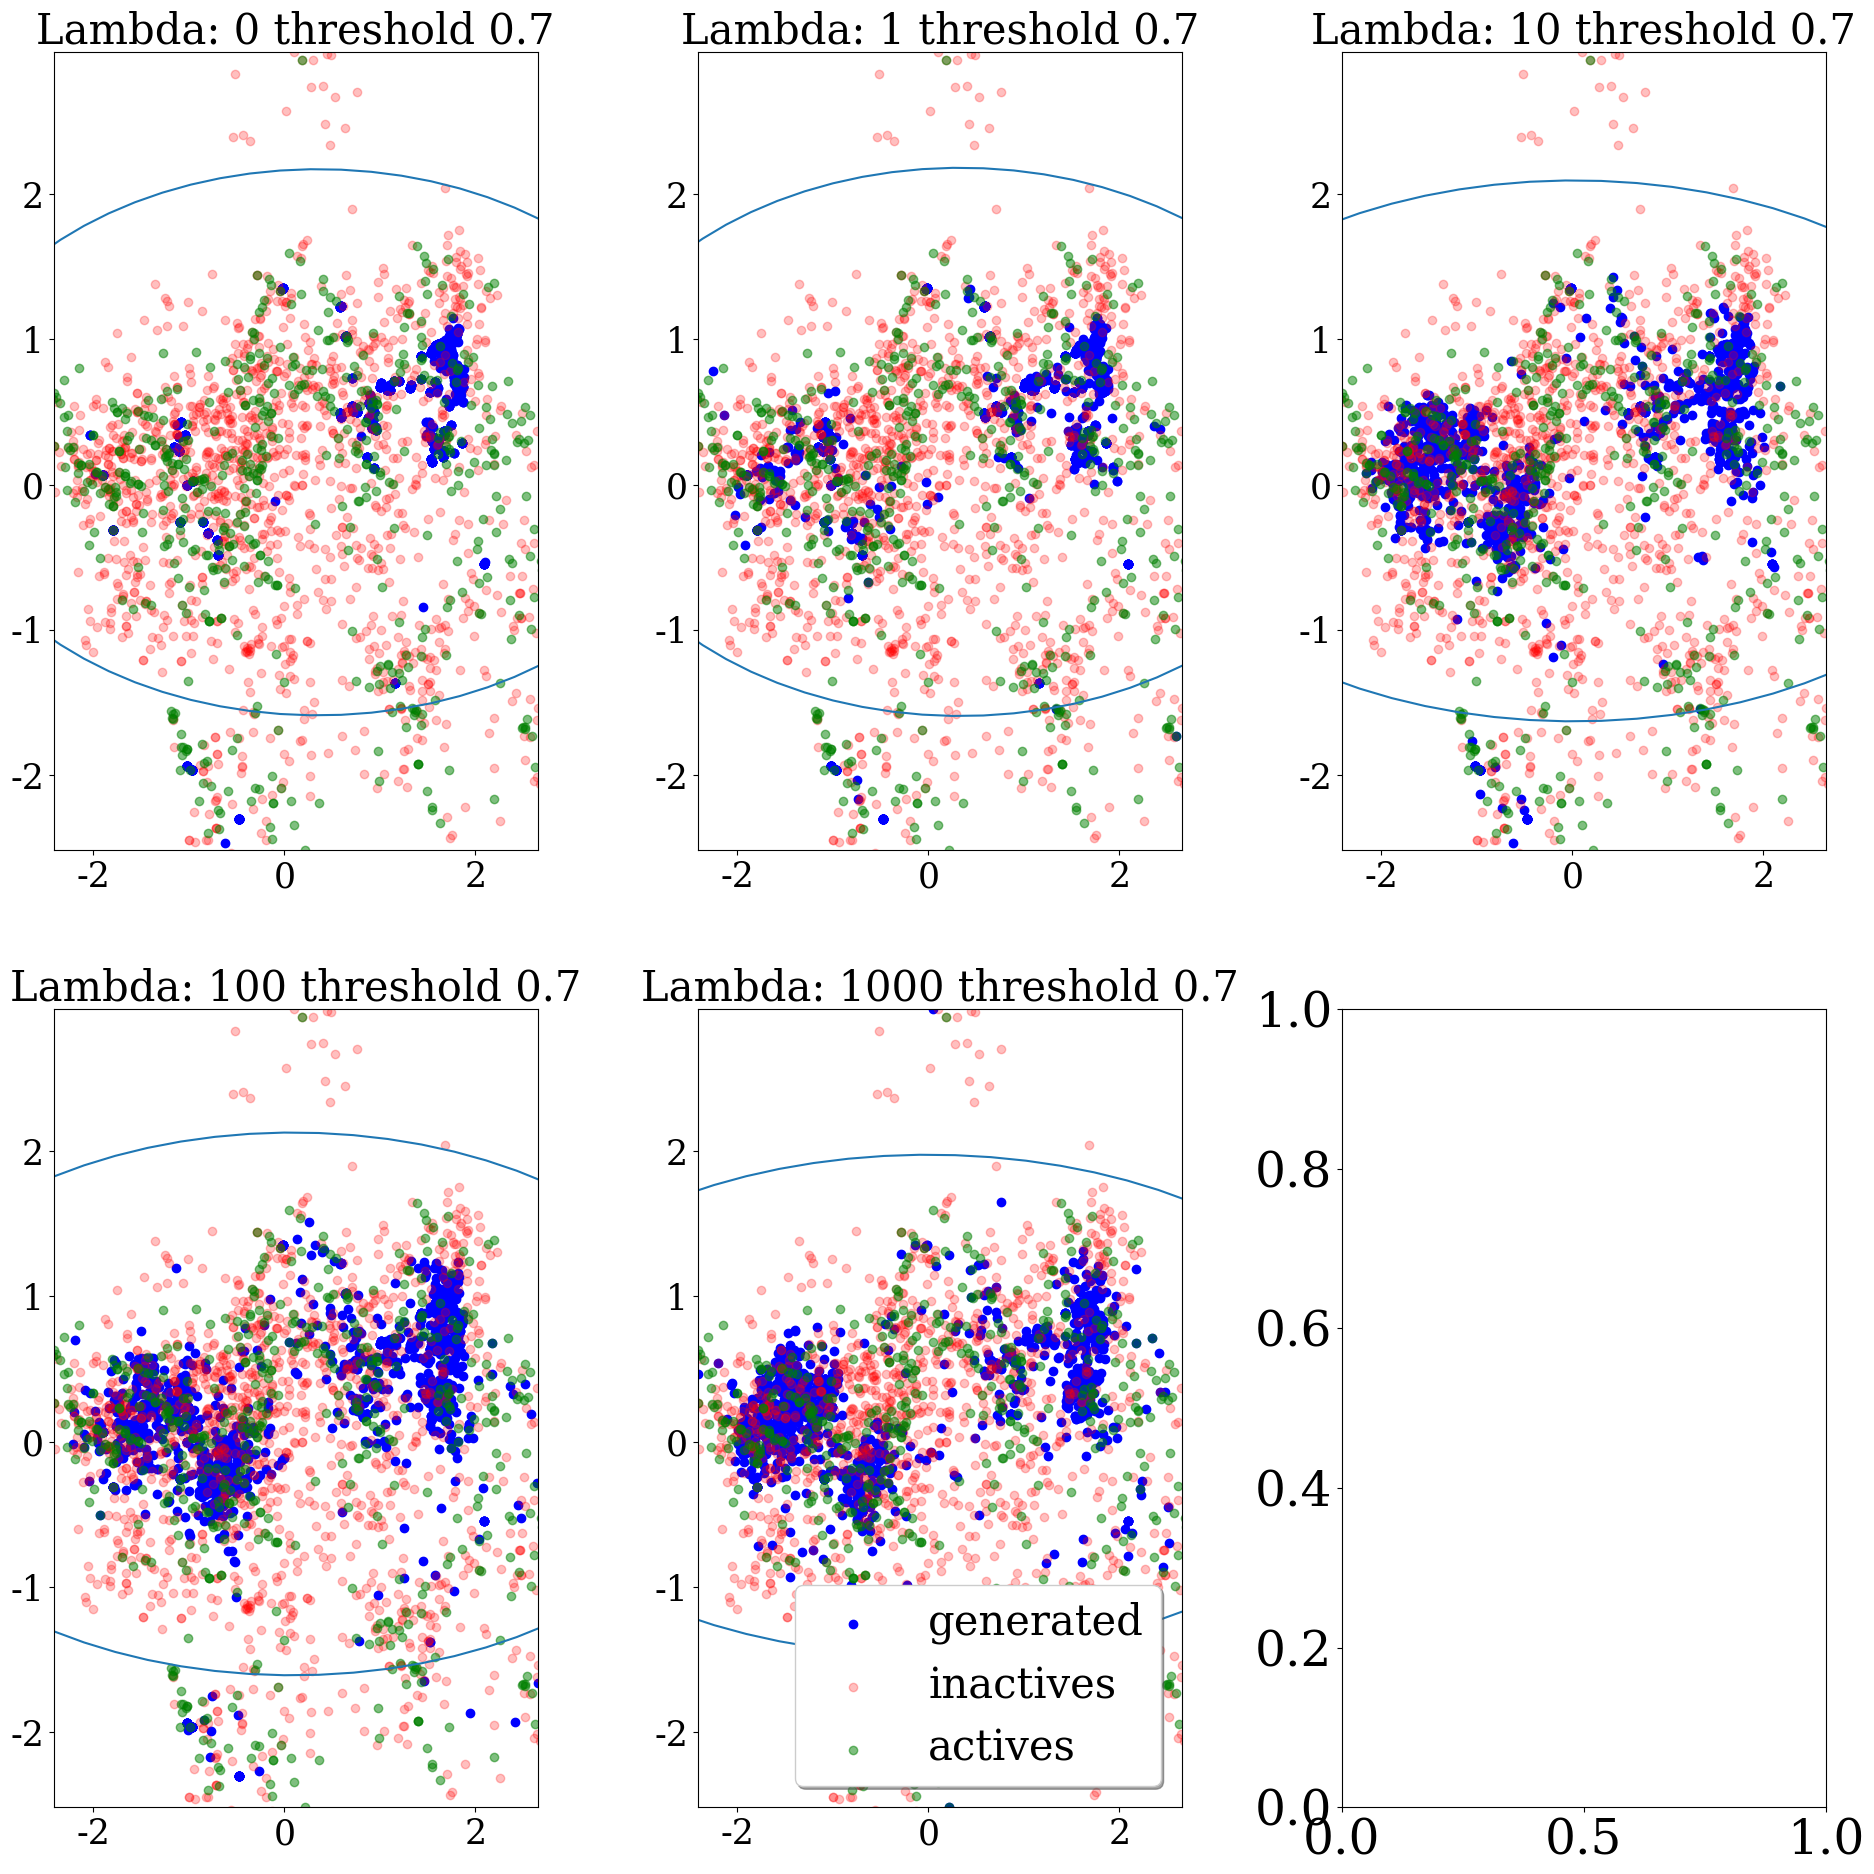

In [17]:
runs_to_display = runs
# runs_to_display = runs
fig, axs = plt.subplots(
    figsize=(20, 20), nrows=max(1, math.ceil(len(runs_to_display) / 3)), ncols=3
)
# suptitle_tmp = 'AD : ' + runs_to_display[0].split('_beta_ ')[0] + '- Effect of beta'
# fig.suptitle(suptitle_tmp, fontsize=30)


for i, run in enumerate(runs_to_display):
    print(runs)
    print(run)
    index = runs.index(run)
    print(index)
    pca_gen = pca_generated[index]
    # For displaying the ellipse arounfd the main cluster
    [x_min, x_max] = [
        np.quantile(pca_gen[:, 0:1], quant),
        np.quantile(pca_gen[:, 0:1], 1.0 - quant),
    ]
    [y_min, y_max] = [
        np.quantile(pca_gen[:, 1:2], quant),
        np.quantile(pca_gen[:, 1:2], 1.0 - quant),
    ]
    center_x = np.mean([x_max, x_min])
    center_y = np.mean([y_max, y_min])
    radius_x = l * (x_max - x_min)
    radius_y = l * (y_max - y_min)
    #
    ax = axs.flatten()[i]
    run_title_tmp = run.split("_beta_ ")[1]
    run_title = "Lambda: " + run_title_tmp
    ax.set_title(run_title.replace("_", " "), fontsize=30)
    ax.set_ylim(y_lims)
    ax.set_xlim(x_lims)
    ax.scatter(pca_gen[:, 0], pca_gen[:, 1], c="b", label="generated", alpha=1)
    ax.scatter(
        pca_inactive[:, 0], pca_inactive[:, 1], c="r", label="inactives", alpha=0.25
    )
    ax.scatter(pca_active[:, 0], pca_active[:, 1], c="g", label="actives", alpha=0.5)
    # Proximity ellipse
    ax.plot(center_x + radius_x * np.cos(t), center_y + radius_y * np.sin(t))
    #
    ax.tick_params(axis="both", which="major", labelsize=25)
    ax.tick_params(axis="both", which="minor", labelsize=25)
    if i == len(runs_to_display) - 1:
        ax.legend(loc="lower right", ncol=1, fancybox=True, shadow=True, fontsize=30)

fig.tight_layout(pad=1.5)
plt.savefig("graphs/DRD2_lambda_effect.pdf", dpi=300)

In [18]:
distant_smiles_dict = {}
for i, run in enumerate(runs_to_display):
    index = runs.index(run)
    smiles_generated = smiles_list[i]
    pca_gen = pca_generated[index]
    [x_min, x_max] = [
        np.quantile(pca_gen[:, 0:1], quant),
        np.quantile(pca_gen[:, 0:1], 1.0 - quant),
    ]
    [y_min, y_max] = [
        np.quantile(pca_gen[:, 1:2], quant),
        np.quantile(pca_gen[:, 1:2], 1.0 - quant),
    ]
    center_x = np.mean([x_max, x_min])
    center_y = np.mean([y_max, y_min])
    radius_x = 1.4 * (x_max - x_min)
    radius_y = 1.4 * (y_max - y_min)
    is_distant = [
        ((x - center_x) ** 2 / radius_x**2 + (y - center_y) ** 2 / radius_y**2 > 1.0)
        for x, y in zip(list(pca_gen[:, 0:1].ravel()), list(pca_gen[:, 1:2].ravel()))
    ]
    is_distant_indexes = [i for i, x in enumerate(is_distant) if x]
    distant_smiles_dict[run] = [smiles_generated[i] for i in is_distant_indexes]

In [19]:
pca_generated = []
entropies = []
clusters = []

pca = PCA(n_components=2).fit(
    np.concatenate((fps_active_as_array, fps_inactive_as_array))
)
pca_active = pca.transform(fps_active_as_array)
pca_inactive = pca.transform(fps_inactive_as_array)
predicted_actives = np.where(clf.predict_proba(ecfp4(smiles_actives))[:, 1] > 0.5)[0]

for i, run in enumerate(runs):
    curr_fps_generated = fps_generated_as_array[i]
    curr_fps_generated_bitv = fps_generated_as_bitv[i]
    pca_generated.append(pca.transform(curr_fps_generated))
    if kmeans:
        curr_clusters = clustering.predict(curr_fps_generated)
    else:
        curr_clusters = [
            find_cluster(fp, centroids_fp) for fp in curr_fps_generated_bitv
        ]
    probs = []
    for i in range(len(np.unique(centroids))):
        probs.append(
            len(np.where(np.array(curr_clusters) == i)[0]) / len(curr_clusters)
        )
    entropy = scipy.stats.entropy(probs) / np.log(len(curr_clusters))
    clusters.append(curr_clusters)
    entropies.append(entropy)

In [20]:
xmin_ymin = np.amin(
    np.vstack([np.amin(p, axis=0) for p in pca_generated]), axis=0
).tolist()
xmax_ymax = np.amax(
    np.vstack([np.amax(p, axis=0) for p in pca_generated]), axis=0
).tolist()
x_lims = [xmin_ymin[0]] + [xmax_ymax[0]]
y_lims = [xmin_ymin[1]] + [xmax_ymax[1]]

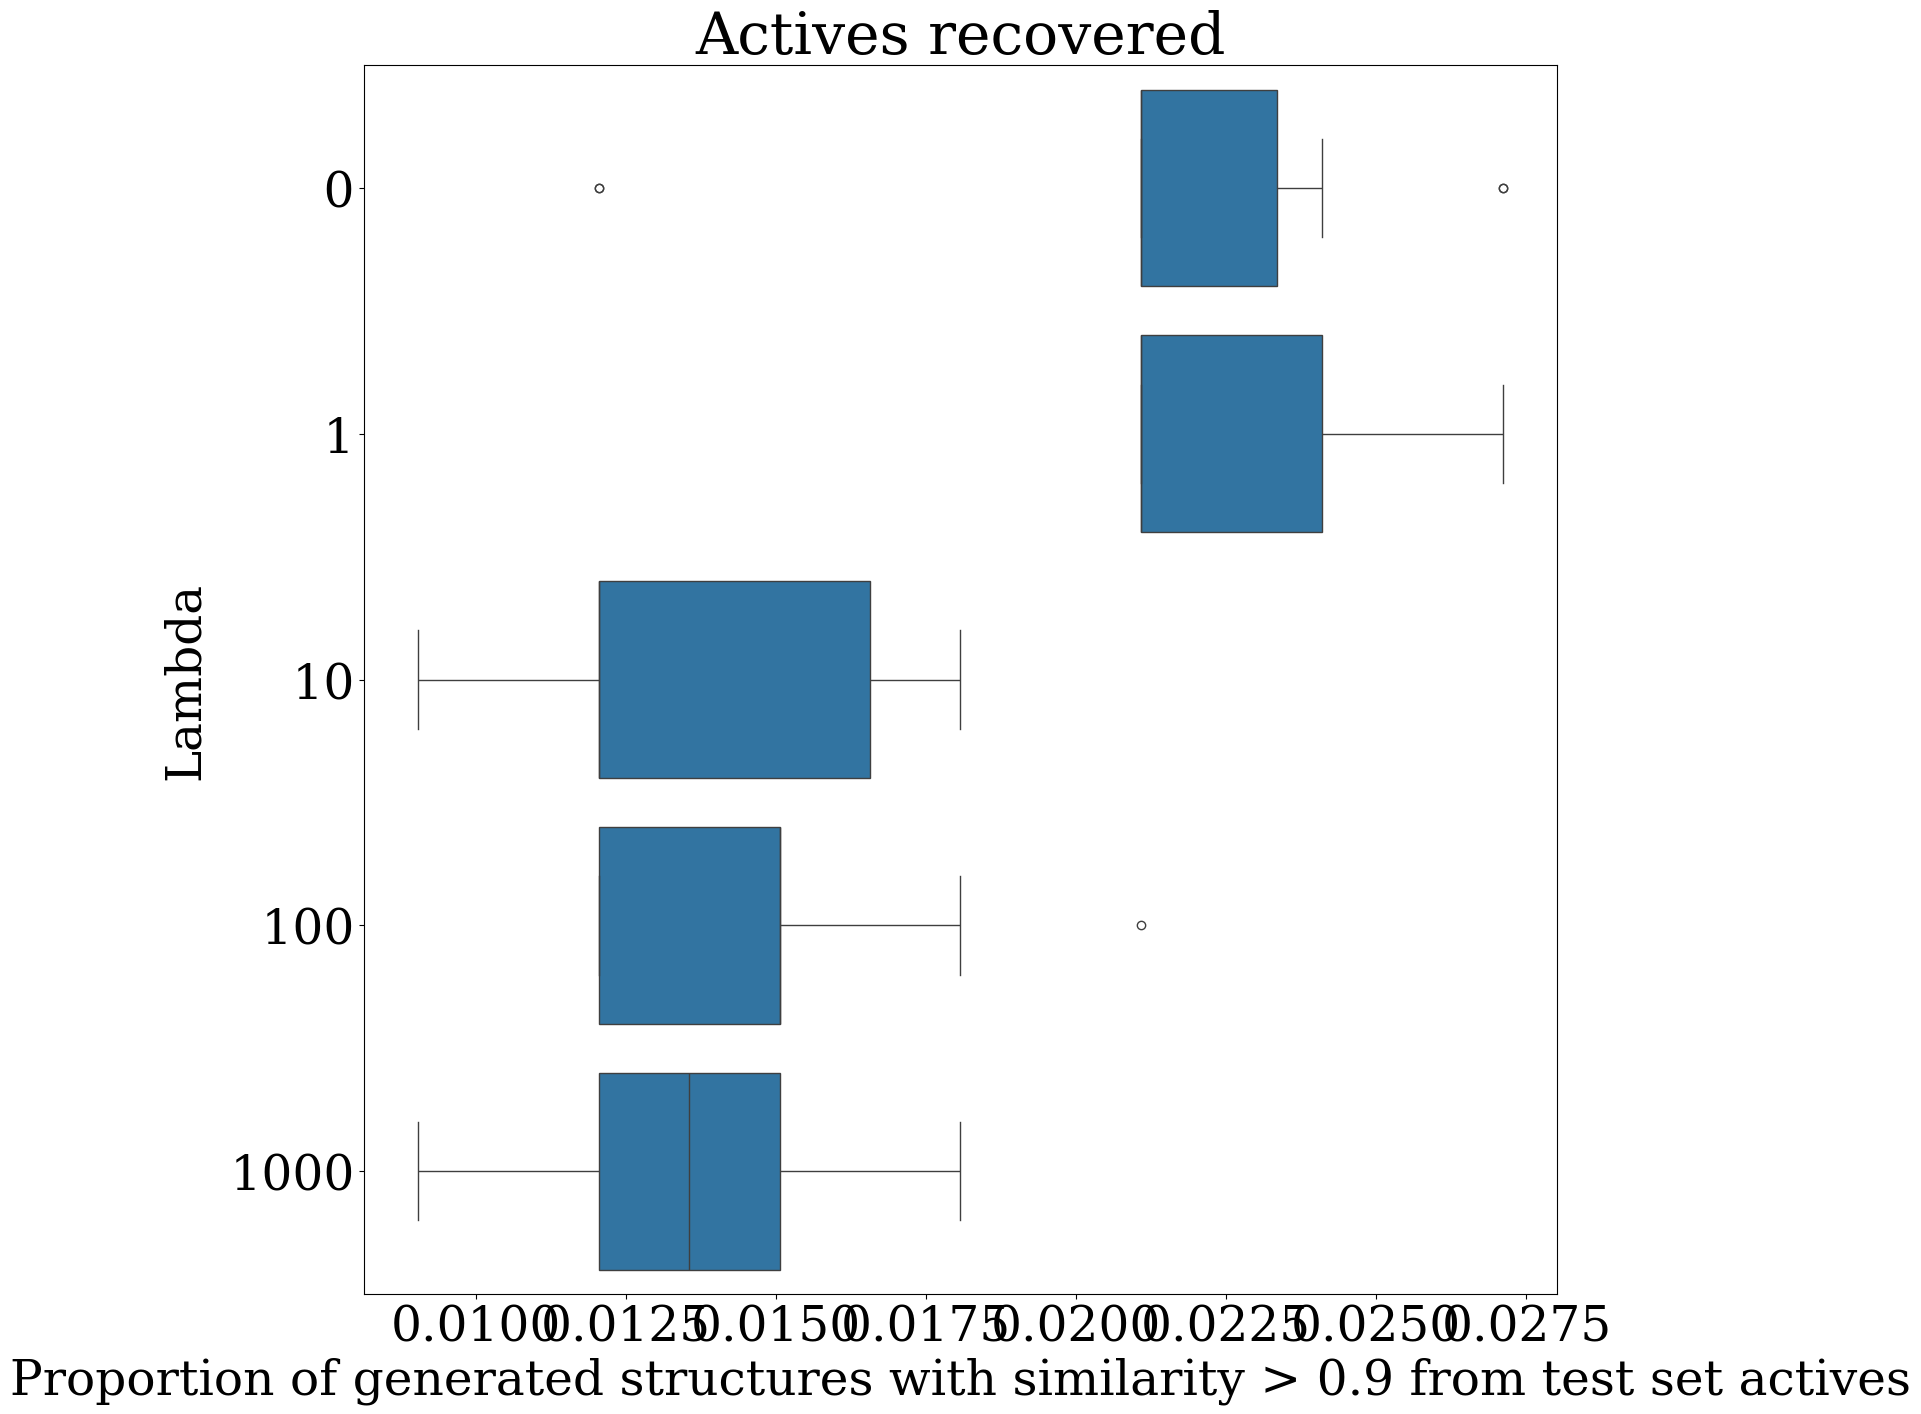

In [47]:
fig = plt.figure(figsize=(15, 15))
novel_recovered = []
titles = []
interval_length = 128

for i, run in enumerate(runs):
    actives_recovered = []
    for seed in range(10):
        smiles_generated = smiles_list[i][
            seed * interval_length : (seed + 1) * interval_length
        ]
        fps_generated = []
        for s in smiles_generated:
            mol = Chem.MolFromSmiles(s)
            fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
        n_new = 0
        for s in np.array(smiles_actives)[predicted_actives]:
            mol = Chem.MolFromSmiles(s)
            if (
                max_tanimoto_similarity(
                    [AllChem.GetMorganFingerprintAsBitVect(mol, 2)], fps_generated
                )
                > 0.90
            ):
                n_new += 1
        novel_recovered.append(n_new / len(predicted_actives))
        titles.append(run.split("_")[-3])
display_df = pd.DataFrame(
    zip(titles, novel_recovered),
    columns=[
        "Lambda",
        "Proportion of generated structures with similarity > 0.9 from test set actives",
    ],
)
chart = sns.boxplot(
    display_df,
    y="Lambda",
    x="Proportion of generated structures with similarity > 0.9 from test set actives",
)

plt.title("Actives recovered")
plt.tight_layout()
plt.savefig(
    "graphs/drd2_actives_recovered_0.9_per_seed.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

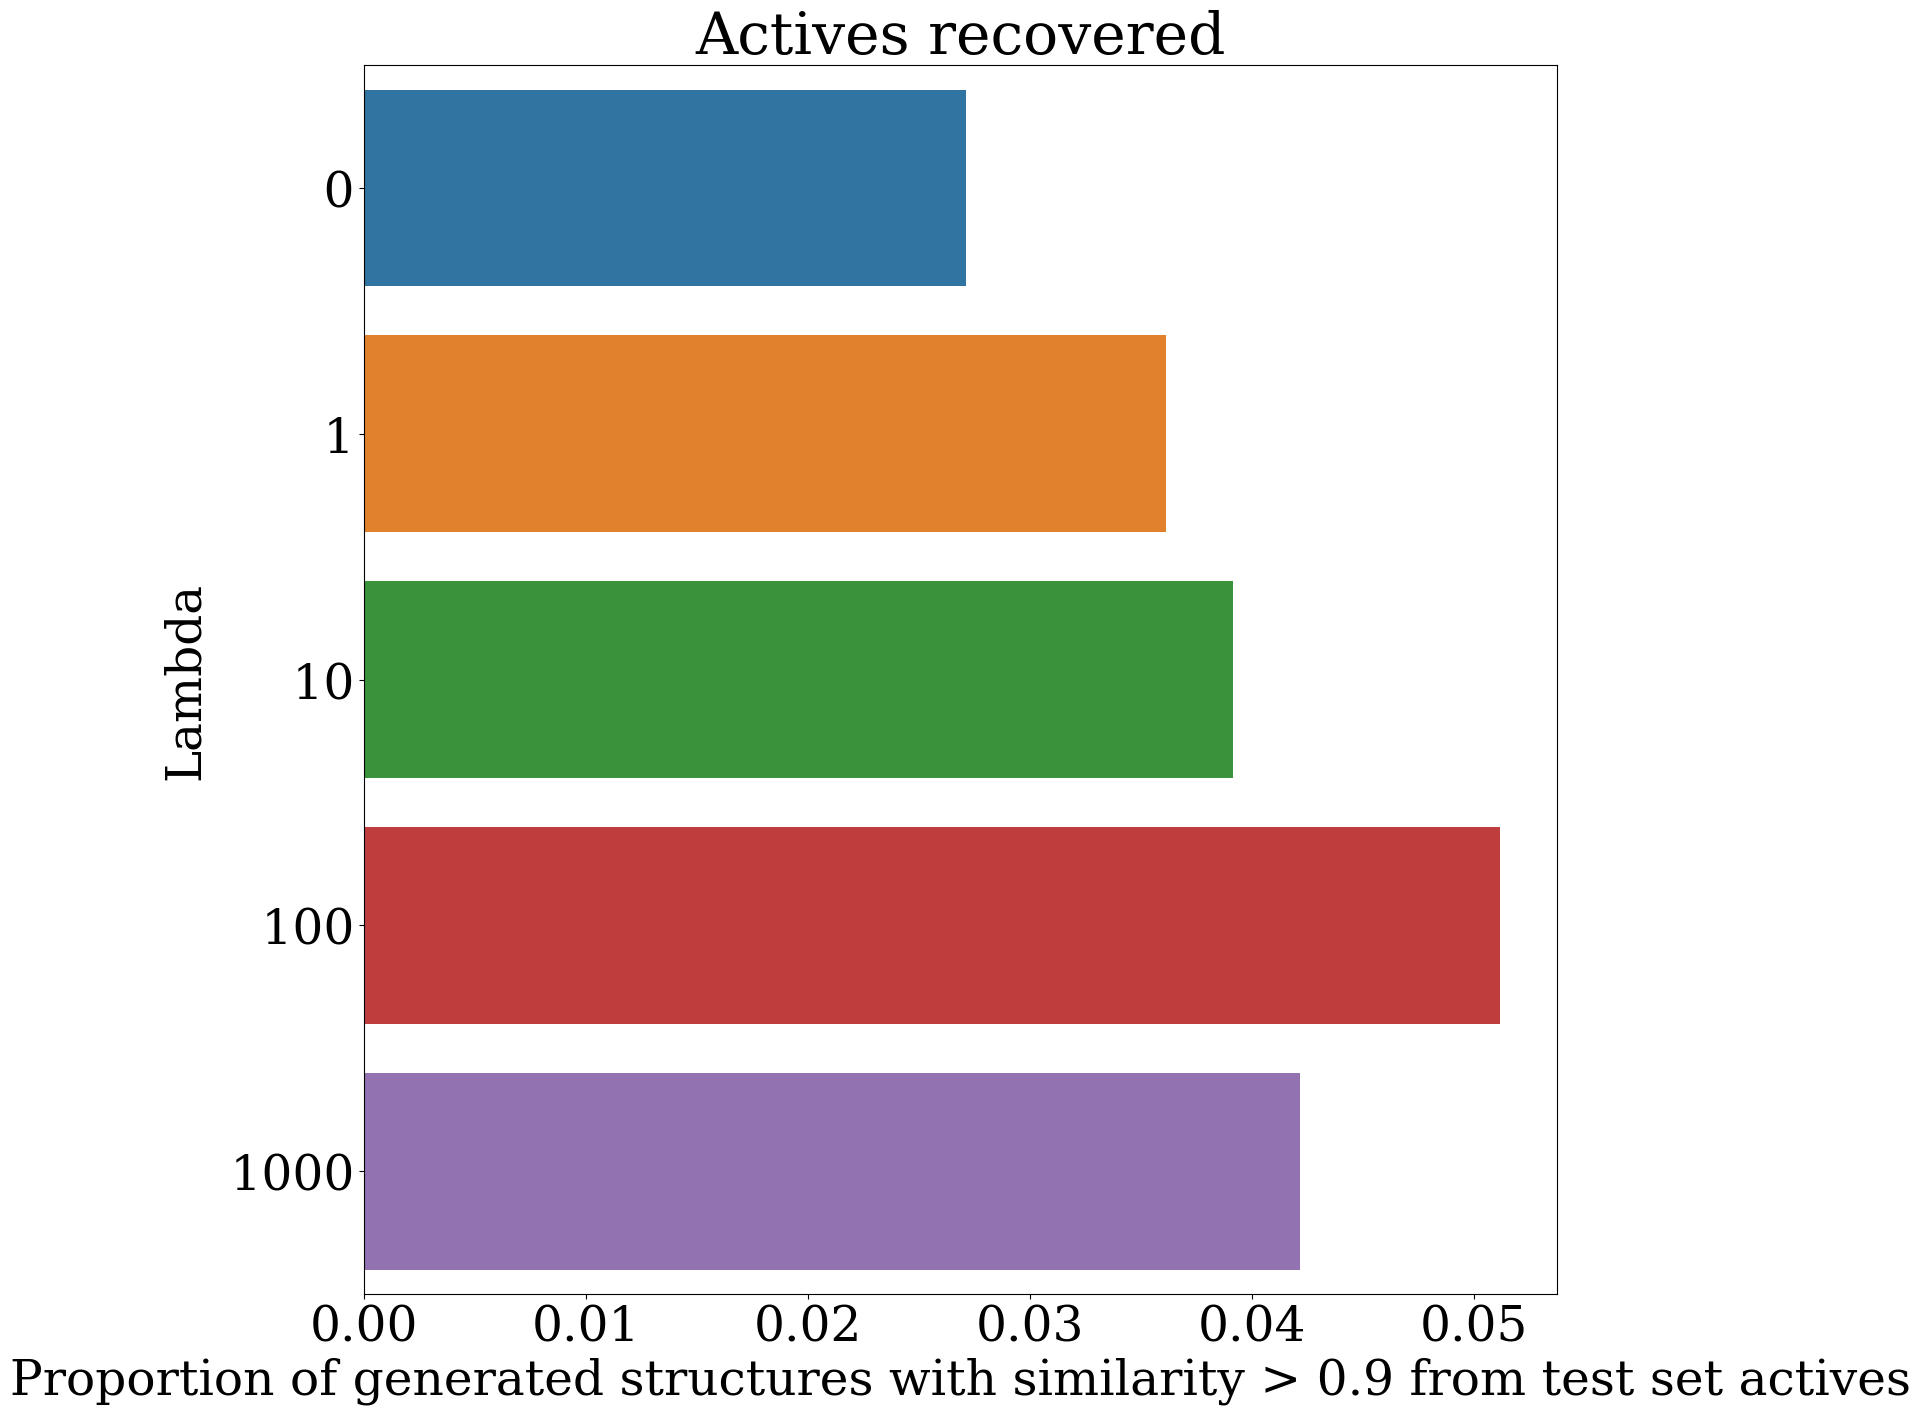

In [48]:
fig = plt.figure(figsize=(15, 15))
novel_recovered = []
titles = []

for i, run in enumerate(runs):
    actives_recovered = []
    smiles_generated = smiles_list[i]
    fps_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    n_new = 0
    for s in np.array(smiles_actives)[predicted_actives]:
        mol = Chem.MolFromSmiles(s)
        if (
            max_tanimoto_similarity(
                [AllChem.GetMorganFingerprintAsBitVect(mol, 2)], fps_generated
            )
            > 0.90
        ):
            n_new += 1
    novel_recovered.append(n_new / len(predicted_actives))
    titles.append(run.split("_")[-3])
display_df = pd.DataFrame(
    zip(titles, novel_recovered),
    columns=[
        "Lambda",
        "Proportion of generated structures with similarity > 0.9 from test set actives",
    ],
)
chart = sns.barplot(
    display_df,
    y="Lambda",
    hue="Lambda",
    x="Proportion of generated structures with similarity > 0.9 from test set actives",
)

plt.title("Actives recovered")
plt.tight_layout()
plt.savefig("graphs/drd2_actives_recovered_0.9.pdf", dpi=300, bbox_inches="tight")
plt.show()

/usr/local/anaconda3/envs/diverse_molgen/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/var/folders/nl/hpnwxlsd6xd8nq2vv1sr5pl80000gn/T/ipykernel_6644/3646851970.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


<Figure size 1500x1500 with 0 Axes>

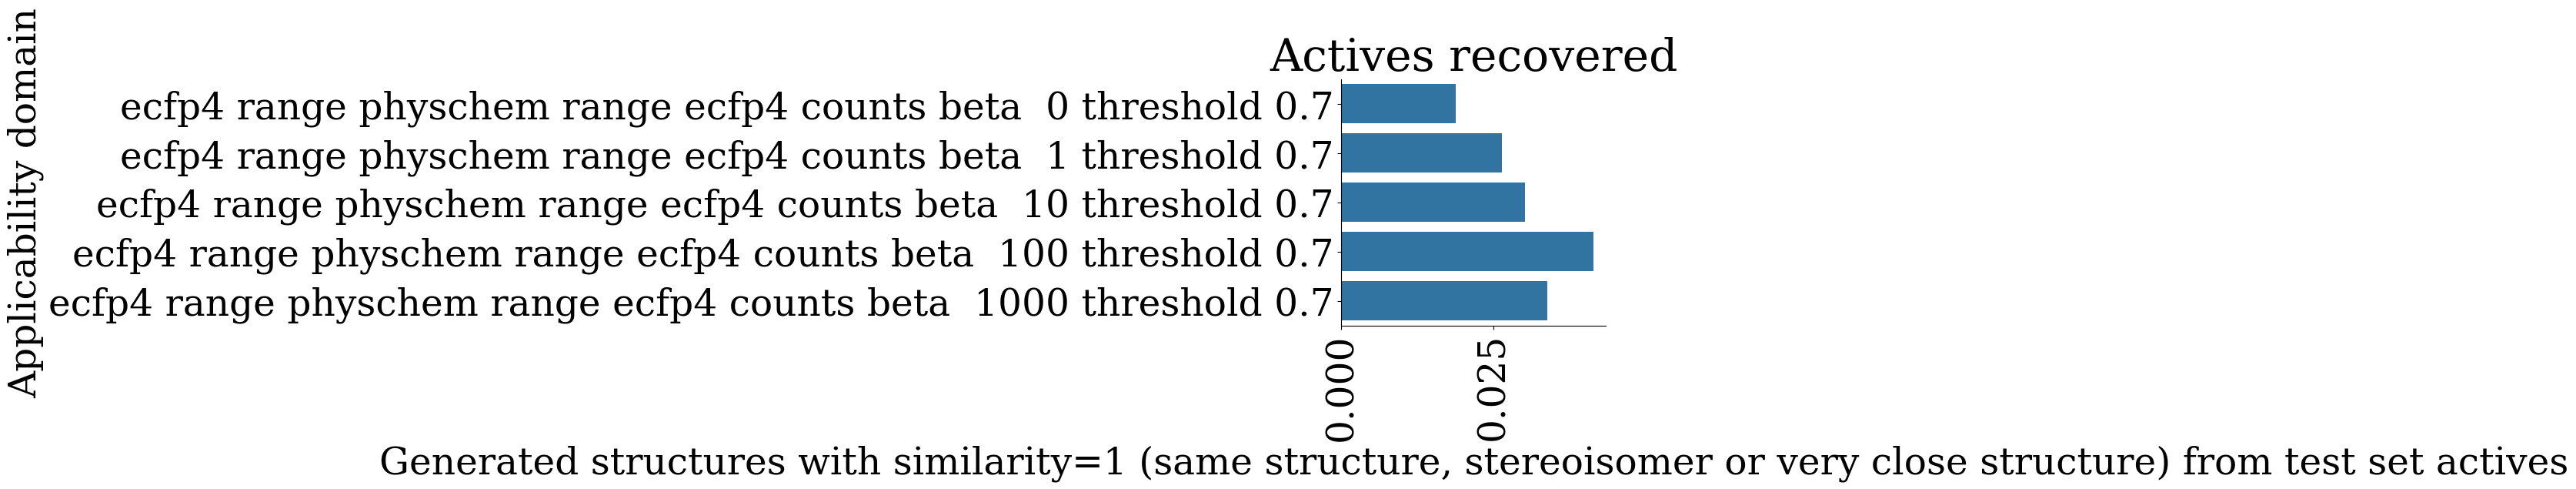

In [22]:
fig = plt.figure(figsize=(15, 15))
novel_recovered = []
titles = []


for i, run in enumerate(runs):
    smiles_generated = smiles_list[i]
    fps_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        fps_generated.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2))
    n_new = 0
    for s in np.array(smiles_actives)[predicted_actives]:
        mol = Chem.MolFromSmiles(s)
        if (
            max_tanimoto_similarity(
                [AllChem.GetMorganFingerprintAsBitVect(mol, 2)], fps_generated
            )
            > 0.99
        ):
            n_new += 1
    novel_recovered.append(n_new / len(predicted_actives))
    titles.append(run.replace("_", " "))
display_df = pd.DataFrame(
    zip(titles, novel_recovered),
    columns=[
        "Applicability domain",
        "Generated structures with similarity=1 (same structure, stereoisomer or very close structure) from test set actives",
    ],
)
chart = sns.catplot(
    y="Applicability domain",
    x="Generated structures with similarity=1 (same structure, stereoisomer or very close structure) from test set actives",
    kind="bar",
    data=display_df,
)
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.title("Actives recovered")
plt.show()

In [23]:
qed_dataset = []
sas_dataset = []
for s in smiles_actives + smiles_inactives:
    mol = Chem.MolFromSmiles(s)
    qed_dataset.append(Descriptors.qed(mol))
    sas_dataset.append(calculateScore(mol))

In [24]:
QED = []
SAS = []

SAS_for_results = []
QED_for_results = []
ad = []
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    qed_generated = []
    sas_generated = []
    for s in smiles_generated:
        mol = Chem.MolFromSmiles(s)
        qed_generated.append(Descriptors.qed(mol))
        sas_generated.append(calculateScore(mol))

        QED.append(Descriptors.qed(mol))
        SAS.append(calculateScore(mol))
        ad.append(run)
    SAS_for_results.append(sas_generated)
    QED_for_results.append(qed_generated)

/var/folders/nl/hpnwxlsd6xd8nq2vv1sr5pl80000gn/T/ipykernel_6644/3505693893.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


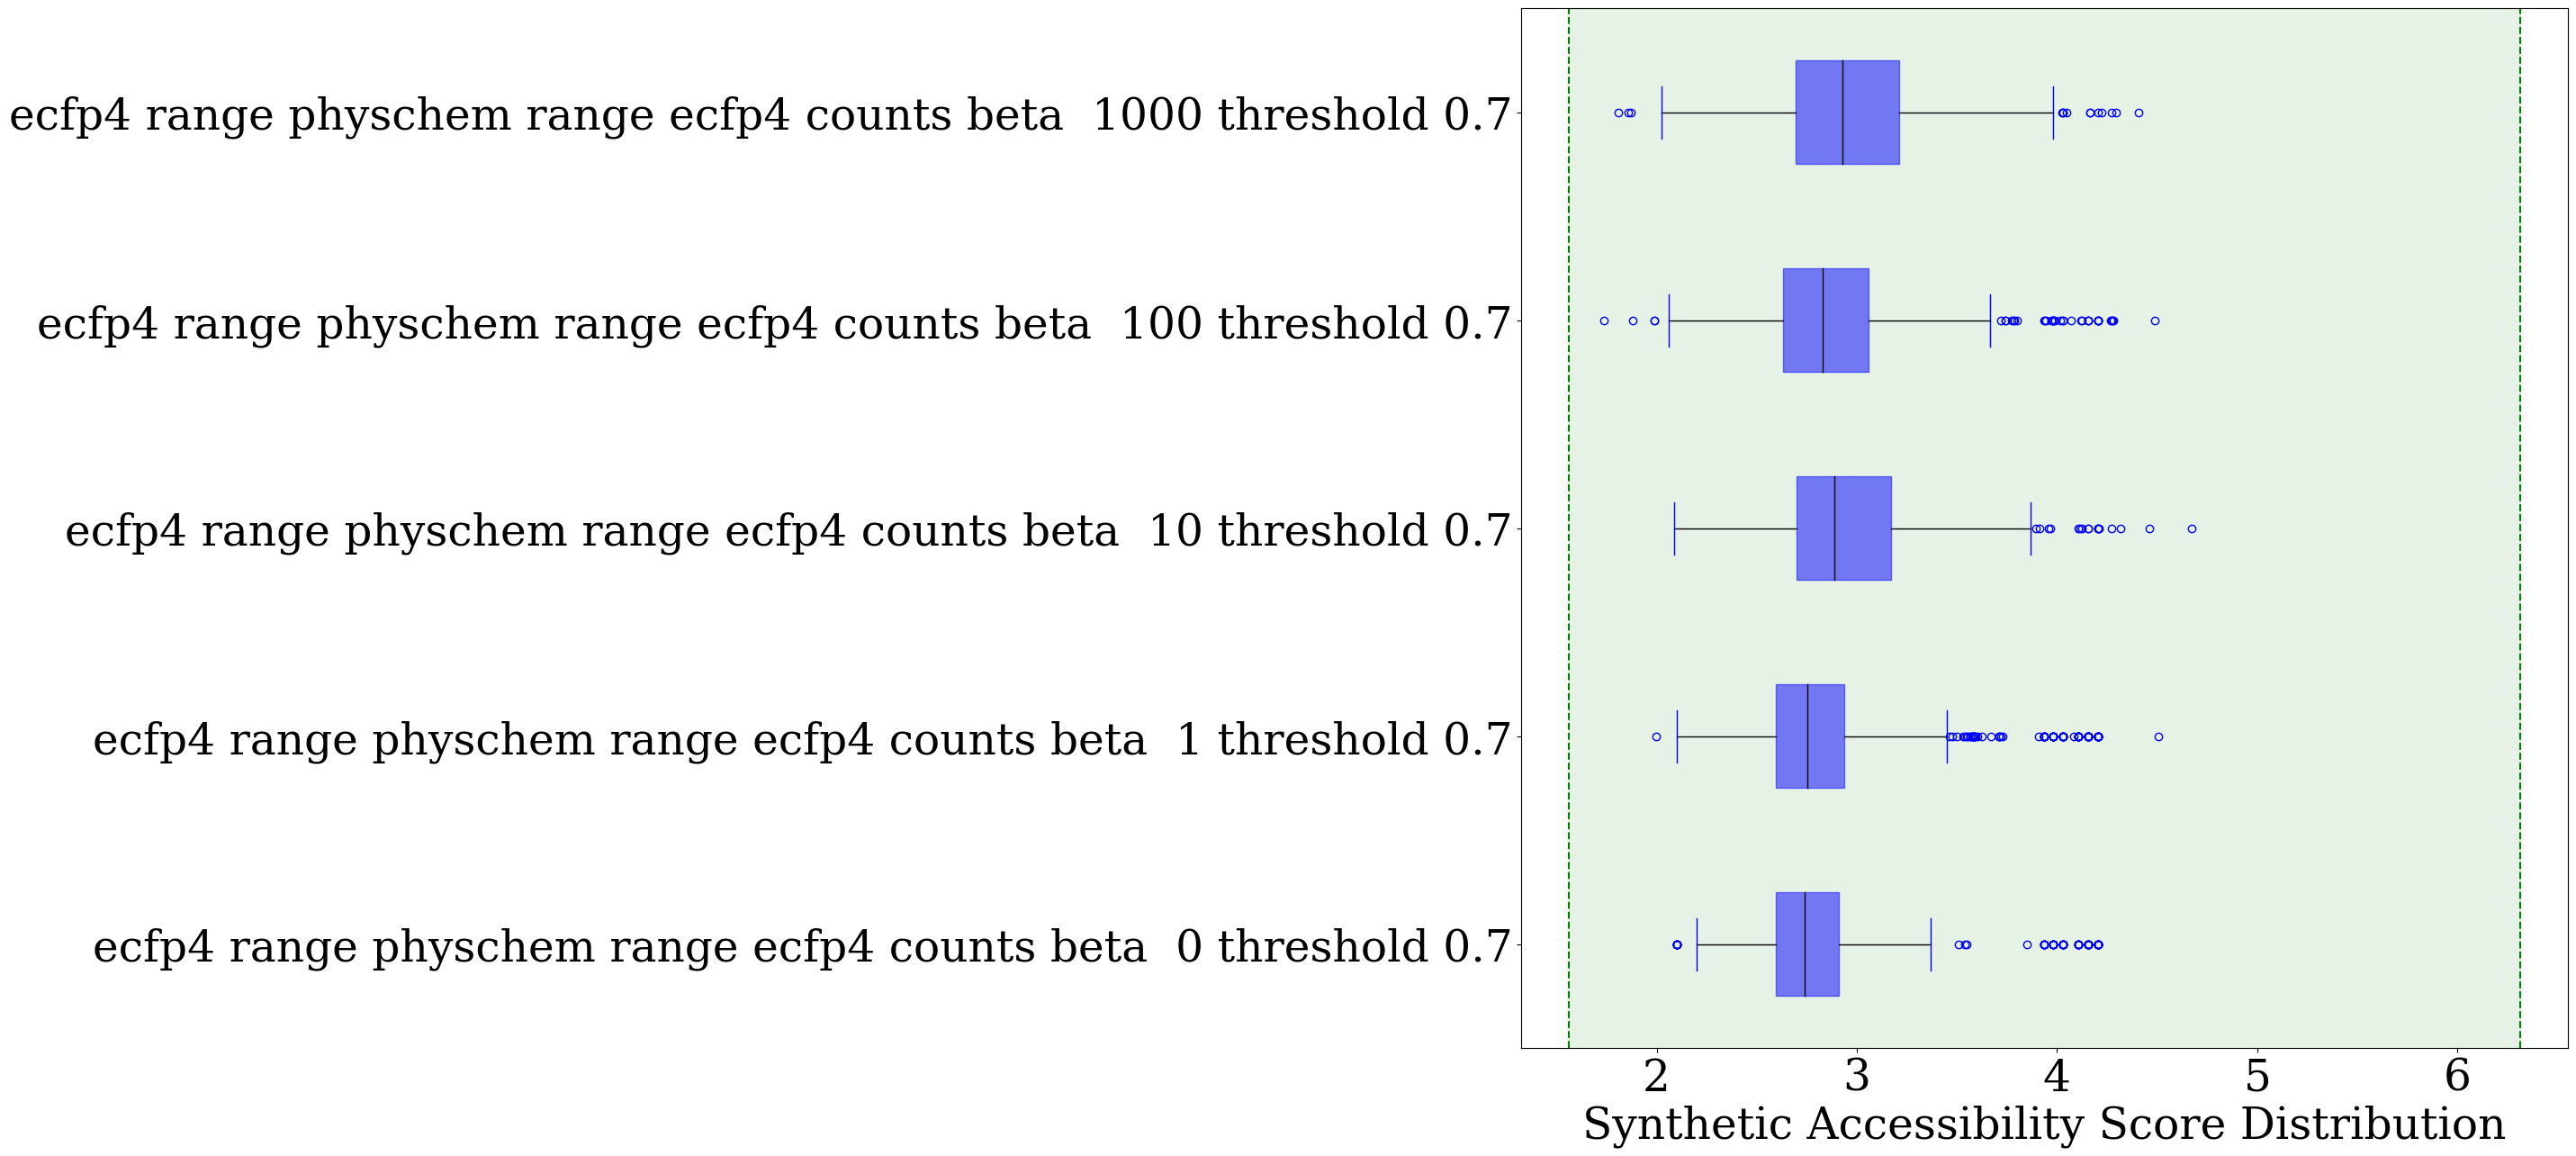

In [25]:
plt.figure(figsize=(15, 15))
# display_df = pd.DataFrame(zip(ad, QED), columns =['Applicability domain', 'QED'])
# chart = sns.boxplot(y="Applicability domain", x="QED", data=display_df)
# ['$' + str(x) + '$' for x in runs]
c = "blue"
box = plt.boxplot(
    SAS_for_results,
    labels=[x.replace("_", " ") for x in runs],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor=c, color=c, alpha=0.5),
    capprops=dict(color=c),
    whiskerprops=dict(color="k"),
    flierprops=dict(color=c, markeredgecolor=c),
    medianprops=dict(color="k"),
)


# plt.boxplot(QED, vert=False)
# plt.yticks(np.arange(len(runs)) + 1, labels=runs, rotation='horizontal')
plt.axvline(
    np.percentile(sas_dataset, 100), ls="--", label="Dataset extreme QED values", c="g"
)
plt.axvline(np.percentile(sas_dataset, 0), ls="--", c="g")
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(
    [np.percentile(sas_dataset, 0), np.percentile(sas_dataset, 100)],
    ymin,
    ymax,
    color="g",
    alpha=0.1,
    label="Valid QED",
)
# plt.legend(loc=4)
plt.xlabel("Synthetic Accessibility Score Distribution")
# plt.ylabel("Applicability domain")
plt.xticks()
plt.yticks()


plt.tight_layout()
# plt.savefig('images/JAK2/SAS_distribution.png', dpi=300)

/var/folders/nl/hpnwxlsd6xd8nq2vv1sr5pl80000gn/T/ipykernel_6644/3489212018.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


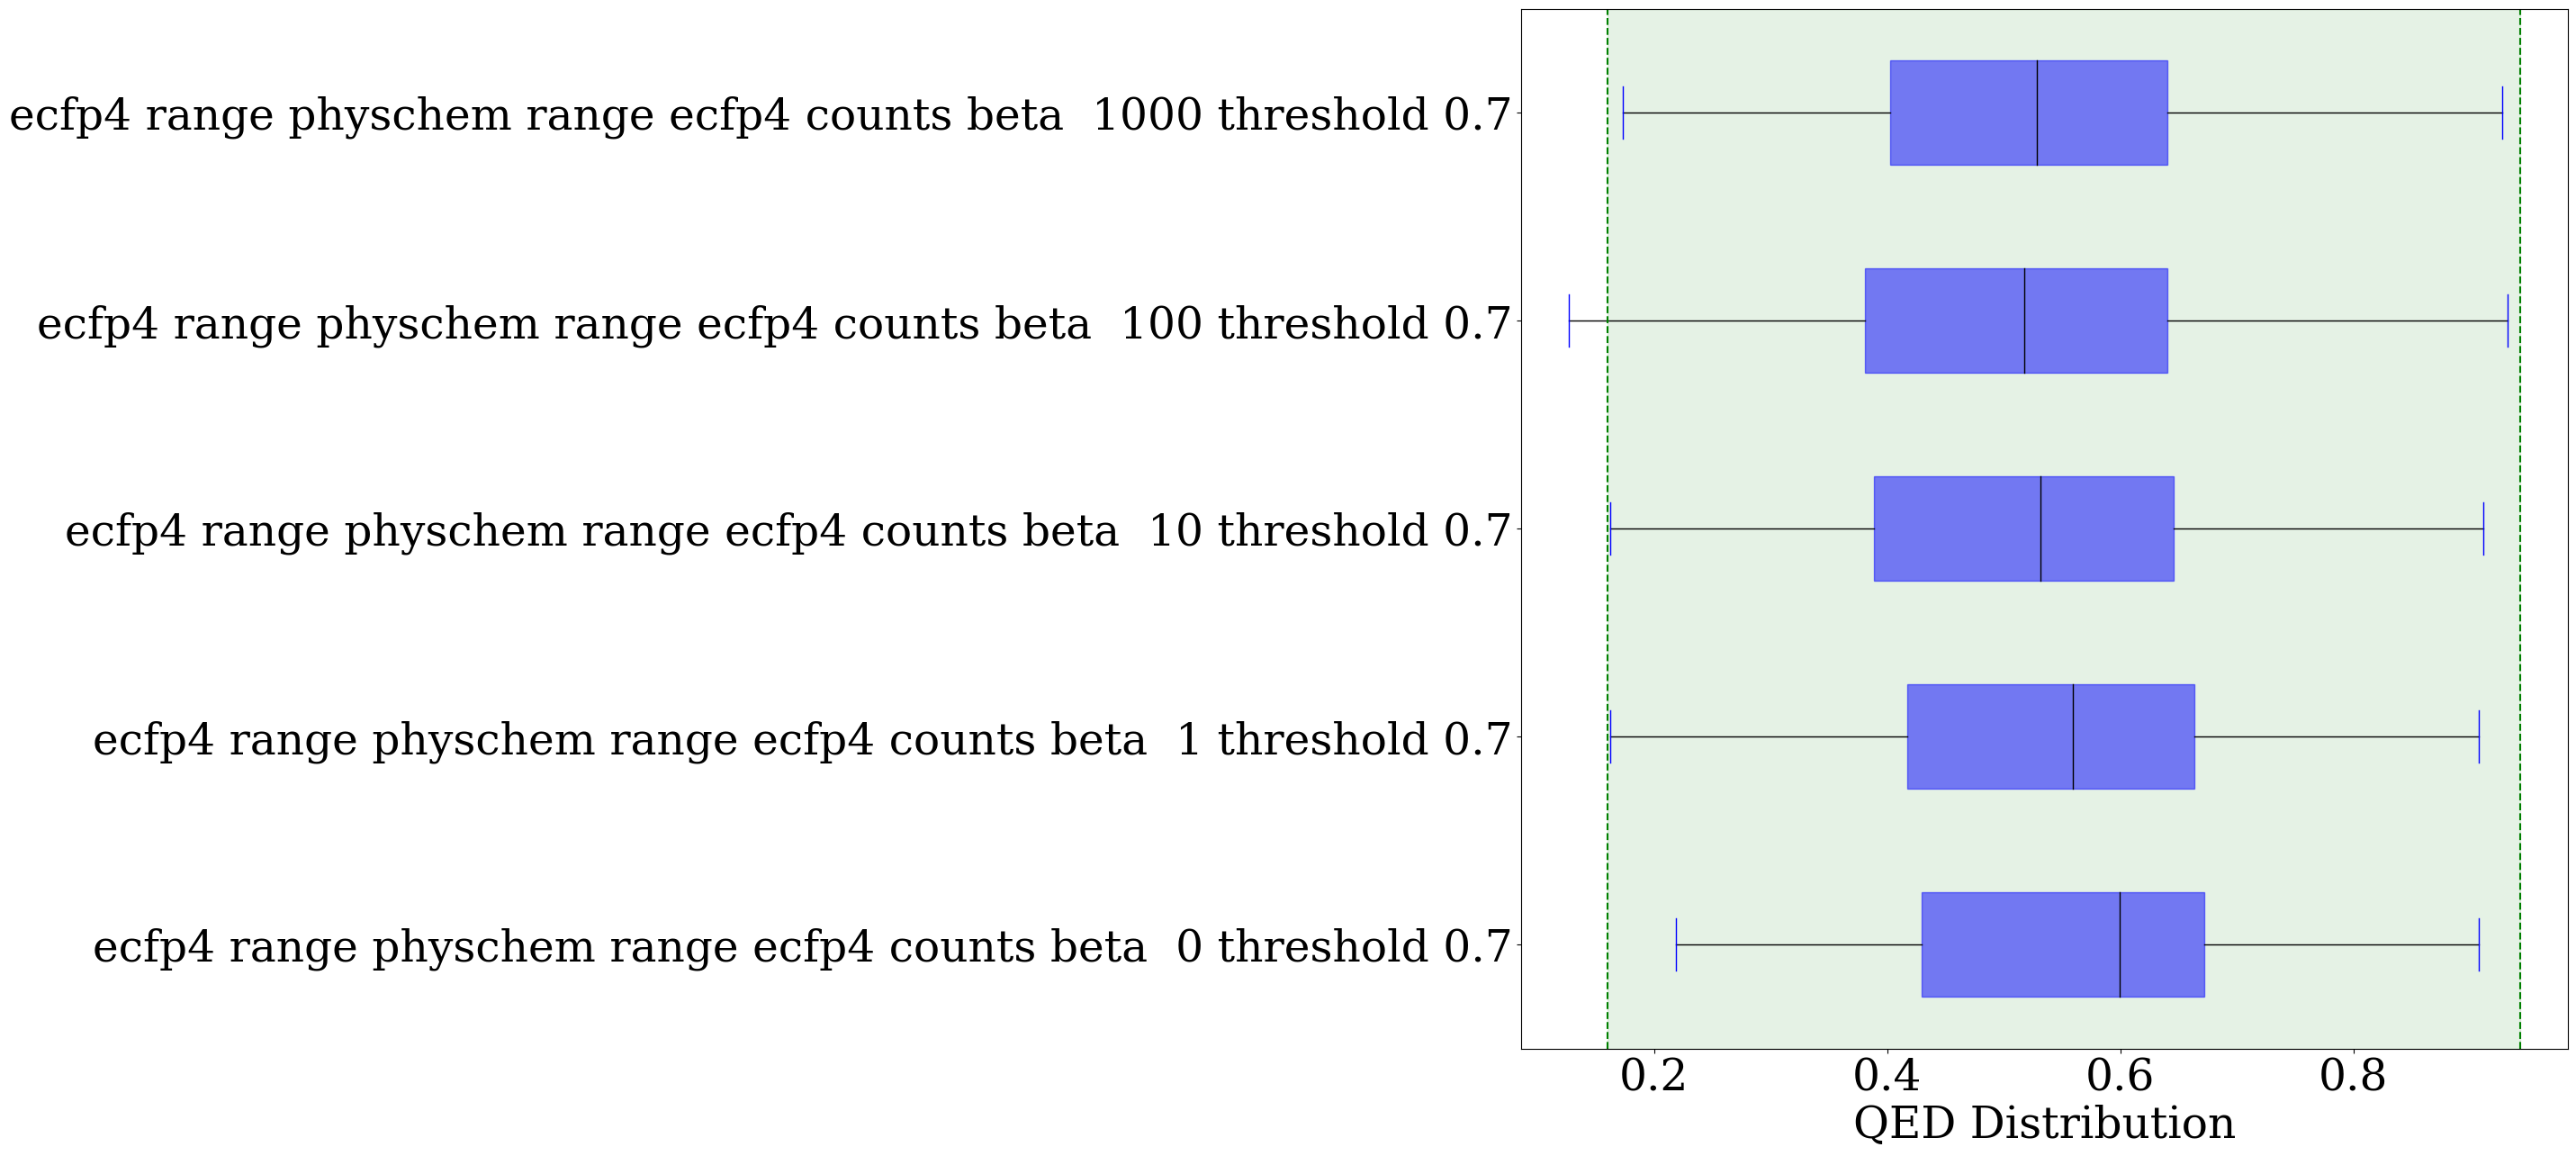

In [26]:
plt.figure(figsize=(15, 15))
# display_df = pd.DataFrame(zip(ad, QED), columns =['Applicability domain', 'QED'])
# chart = sns.boxplot(y="Applicability domain", x="QED", data=display_df)
# ['$' + str(x) + '$' for x in runs]
c = "blue"
box = plt.boxplot(
    QED_for_results,
    labels=[x.replace("_", " ") for x in runs],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor=c, color=c, alpha=0.5),
    capprops=dict(color=c),
    whiskerprops=dict(color="k"),
    flierprops=dict(color=c, markeredgecolor=c),
    medianprops=dict(color="k"),
)


# plt.boxplot(QED, vert=False)
# plt.yticks(np.arange(len(runs)) + 1, labels=runs, rotation='horizontal')
plt.axvline(
    np.percentile(qed_dataset, 100), ls="--", label="Dataset extreme QED values", c="g"
)
plt.axvline(np.percentile(qed_dataset, 0), ls="--", c="g")
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(
    [np.percentile(qed_dataset, 0), np.percentile(qed_dataset, 100)],
    ymin,
    ymax,
    color="g",
    alpha=0.1,
    label="Valid QED",
)
# plt.legend(loc=4)
plt.xlabel("QED Distribution")
# plt.ylabel("Applicability domain")
plt.xticks()
plt.yticks()


plt.tight_layout()
# plt.savefig('images/JAK2/QED_distribution.png', dpi=300)

# Comparing different AD's outputs

In [27]:
from utils import (
    qualitative_analysis,
    return_distribution_cycle_size,
    return_distribution_mw,
    return_distribution_halogen,
    return_distribution_heteroatoms,
    return_distribution_radicals,
    return_distribution_sulphur,
    qualitative_analysis,
)

In [28]:
average_similarities = []
max_similarities = []
common_molecules = {}
for i, run in enumerate(runs):
    avg_sims = []
    max_sim = []
    smiles_generated = smiles_list[i]
    fps_generated = fps_generated_as_bitv[i]
    for j, comparison_run in enumerate(runs):
        smiles_generated = smiles_list[j]
        fps_other = fps_generated_as_bitv[j]
        if j < i:
            indexes, indexes_other = indexes_identical_fps(fps_generated, fps_other)
            common_molecules[run + "_vs_" + comparison_run] = [indexes, indexes_other]
        avg_sims.append(average_tanimoto_similarity(fps_generated, fps_other))
        max_sim.append(max_tanimoto_similarity(fps_generated, fps_other))
    average_similarities.append(avg_sims)
    max_similarities.append(max_sim)

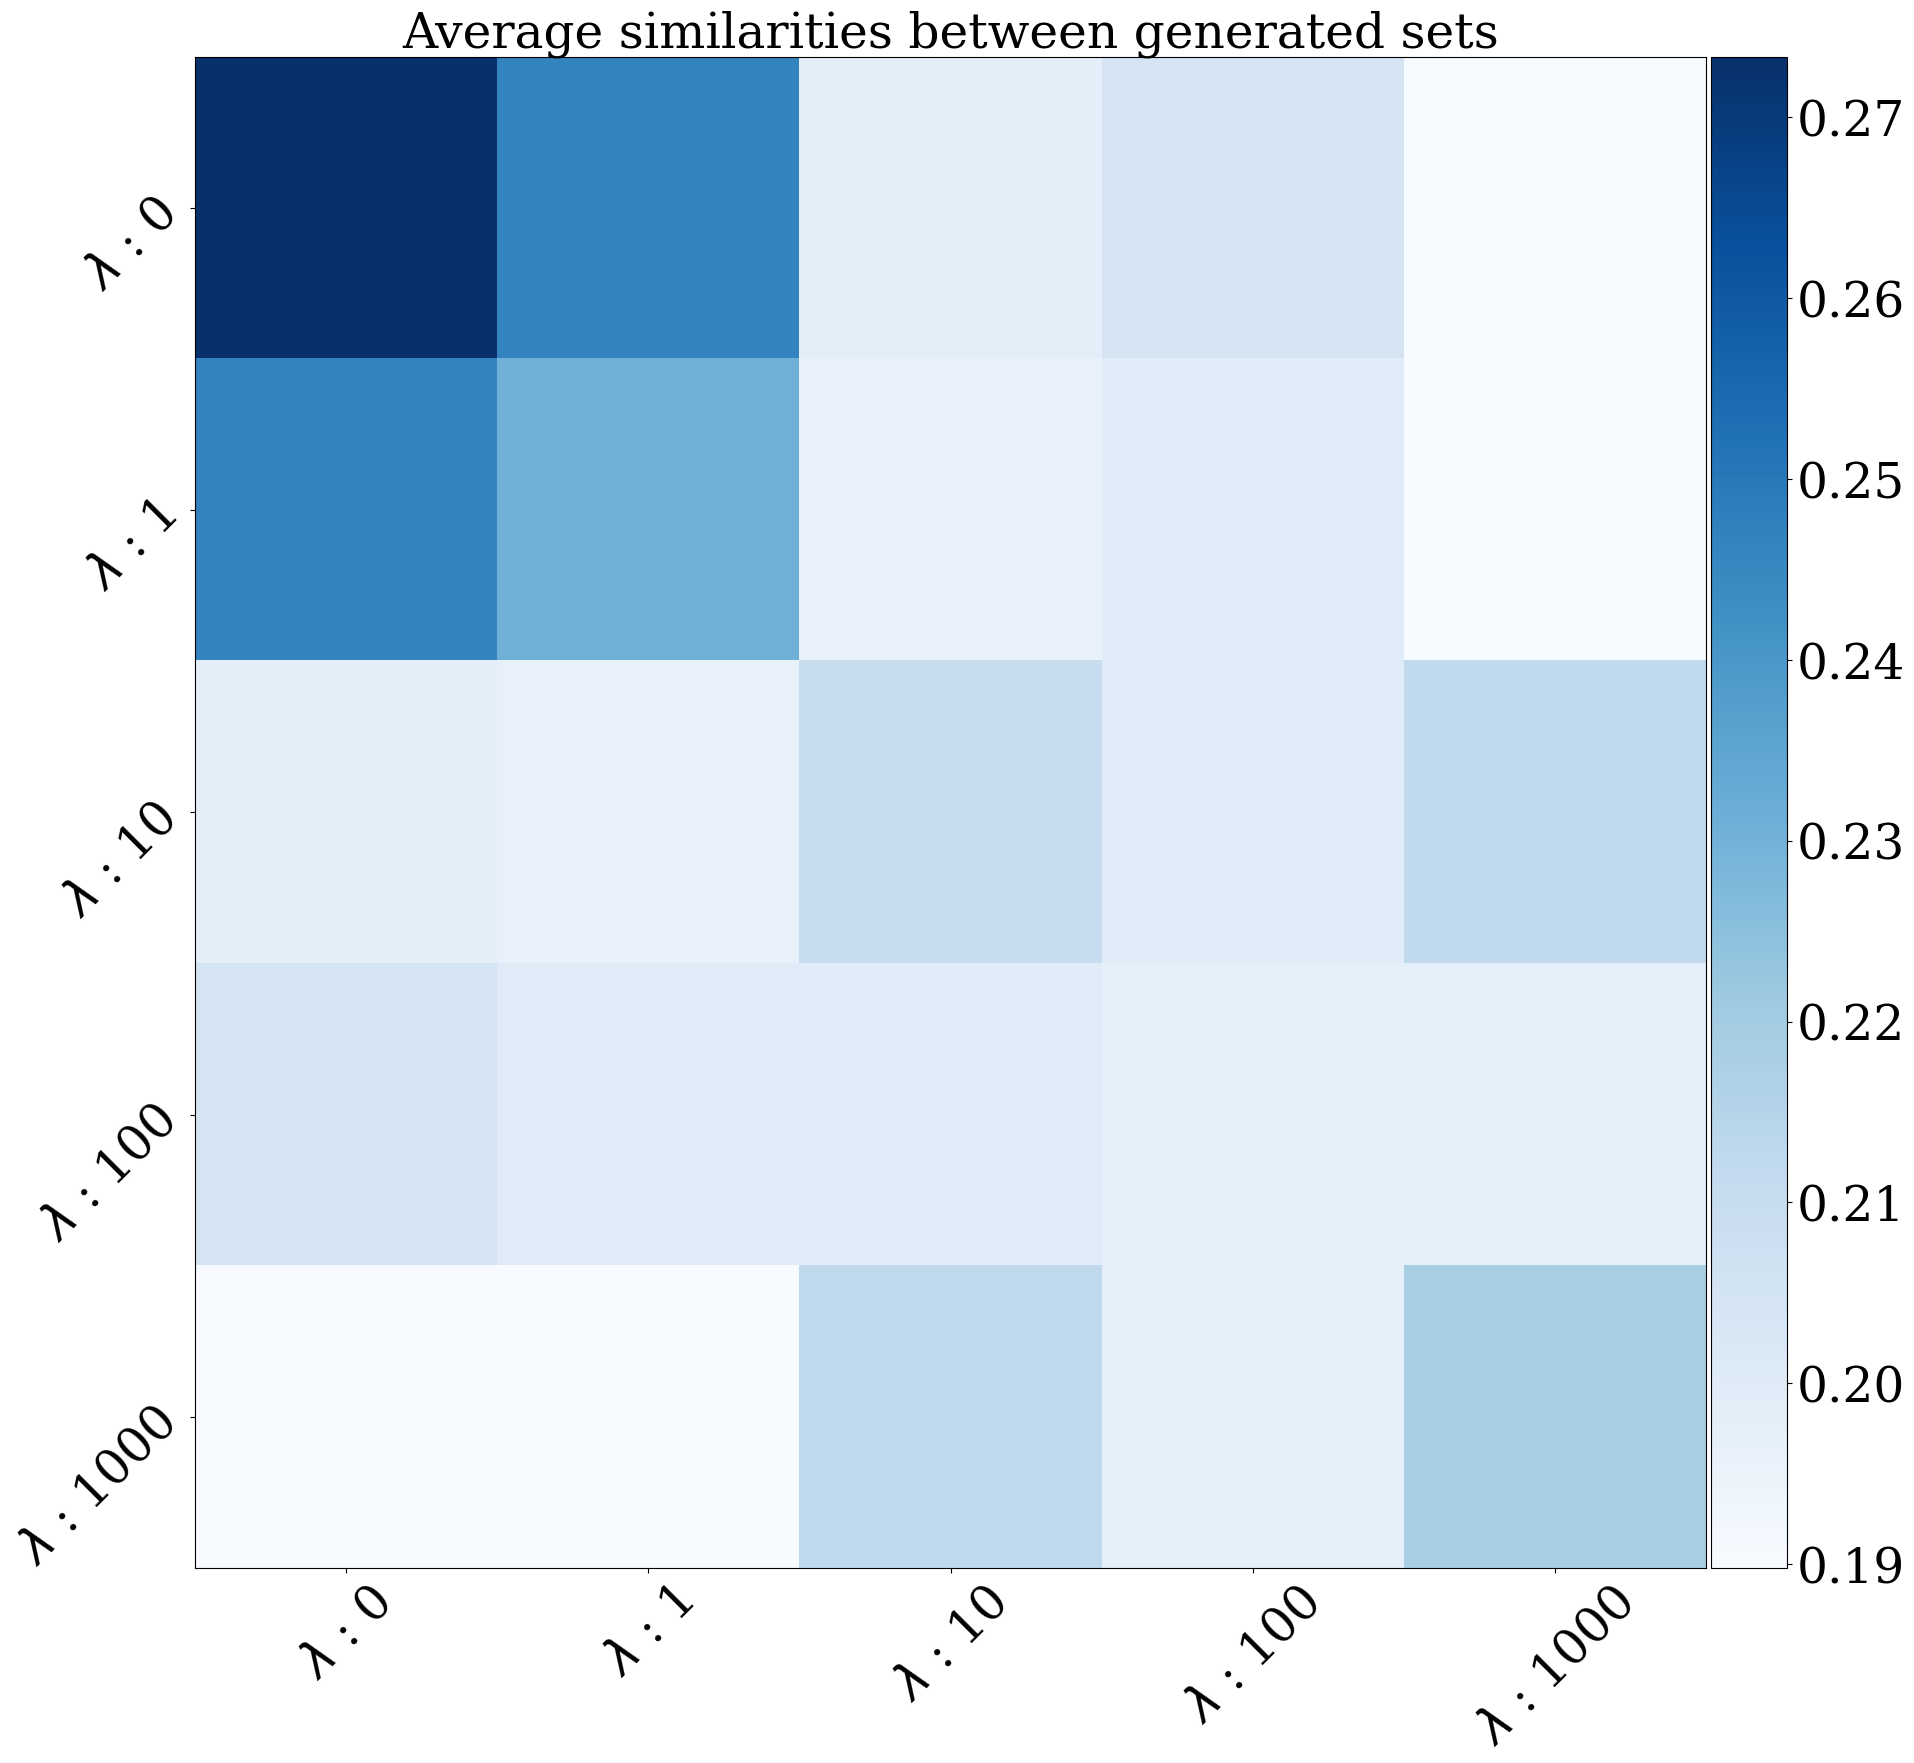

In [29]:
# Displays average generated set - generated set similarities
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = []
for x in runs:
    run_title_tmp = x.split("_beta_ ")[1]
    run_title = r"$\lambda$ : " + run_title_tmp.split("_")[0]
    labels.append(run_title.replace("_", " "))

fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=1)

fig.tight_layout(pad=1.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)


ax.set_title("Average similarities between generated sets", fontsize=35)

im = ax.imshow(np.array(average_similarities), cmap="Blues")
ax.set_yticks(ticks=range(len(labels)))
ax.set_xticks(ticks=range(len(labels)))
ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels, rotation=45)
ax.tick_params(axis="both", which="major", labelsize=35)
ax.tick_params(axis="both", which="minor", labelsize=35)
# plt.colorbar()
fig.tight_layout(pad=3.0)
cbar = plt.colorbar(im, cax=cax, orientation="vertical")
cbar.ax.tick_params(labelsize=35)
ax.grid(False)

plt.tight_layout()
plt.savefig("graphs/similarities_drd2.png", dpi=300, bbox_inches="tight")

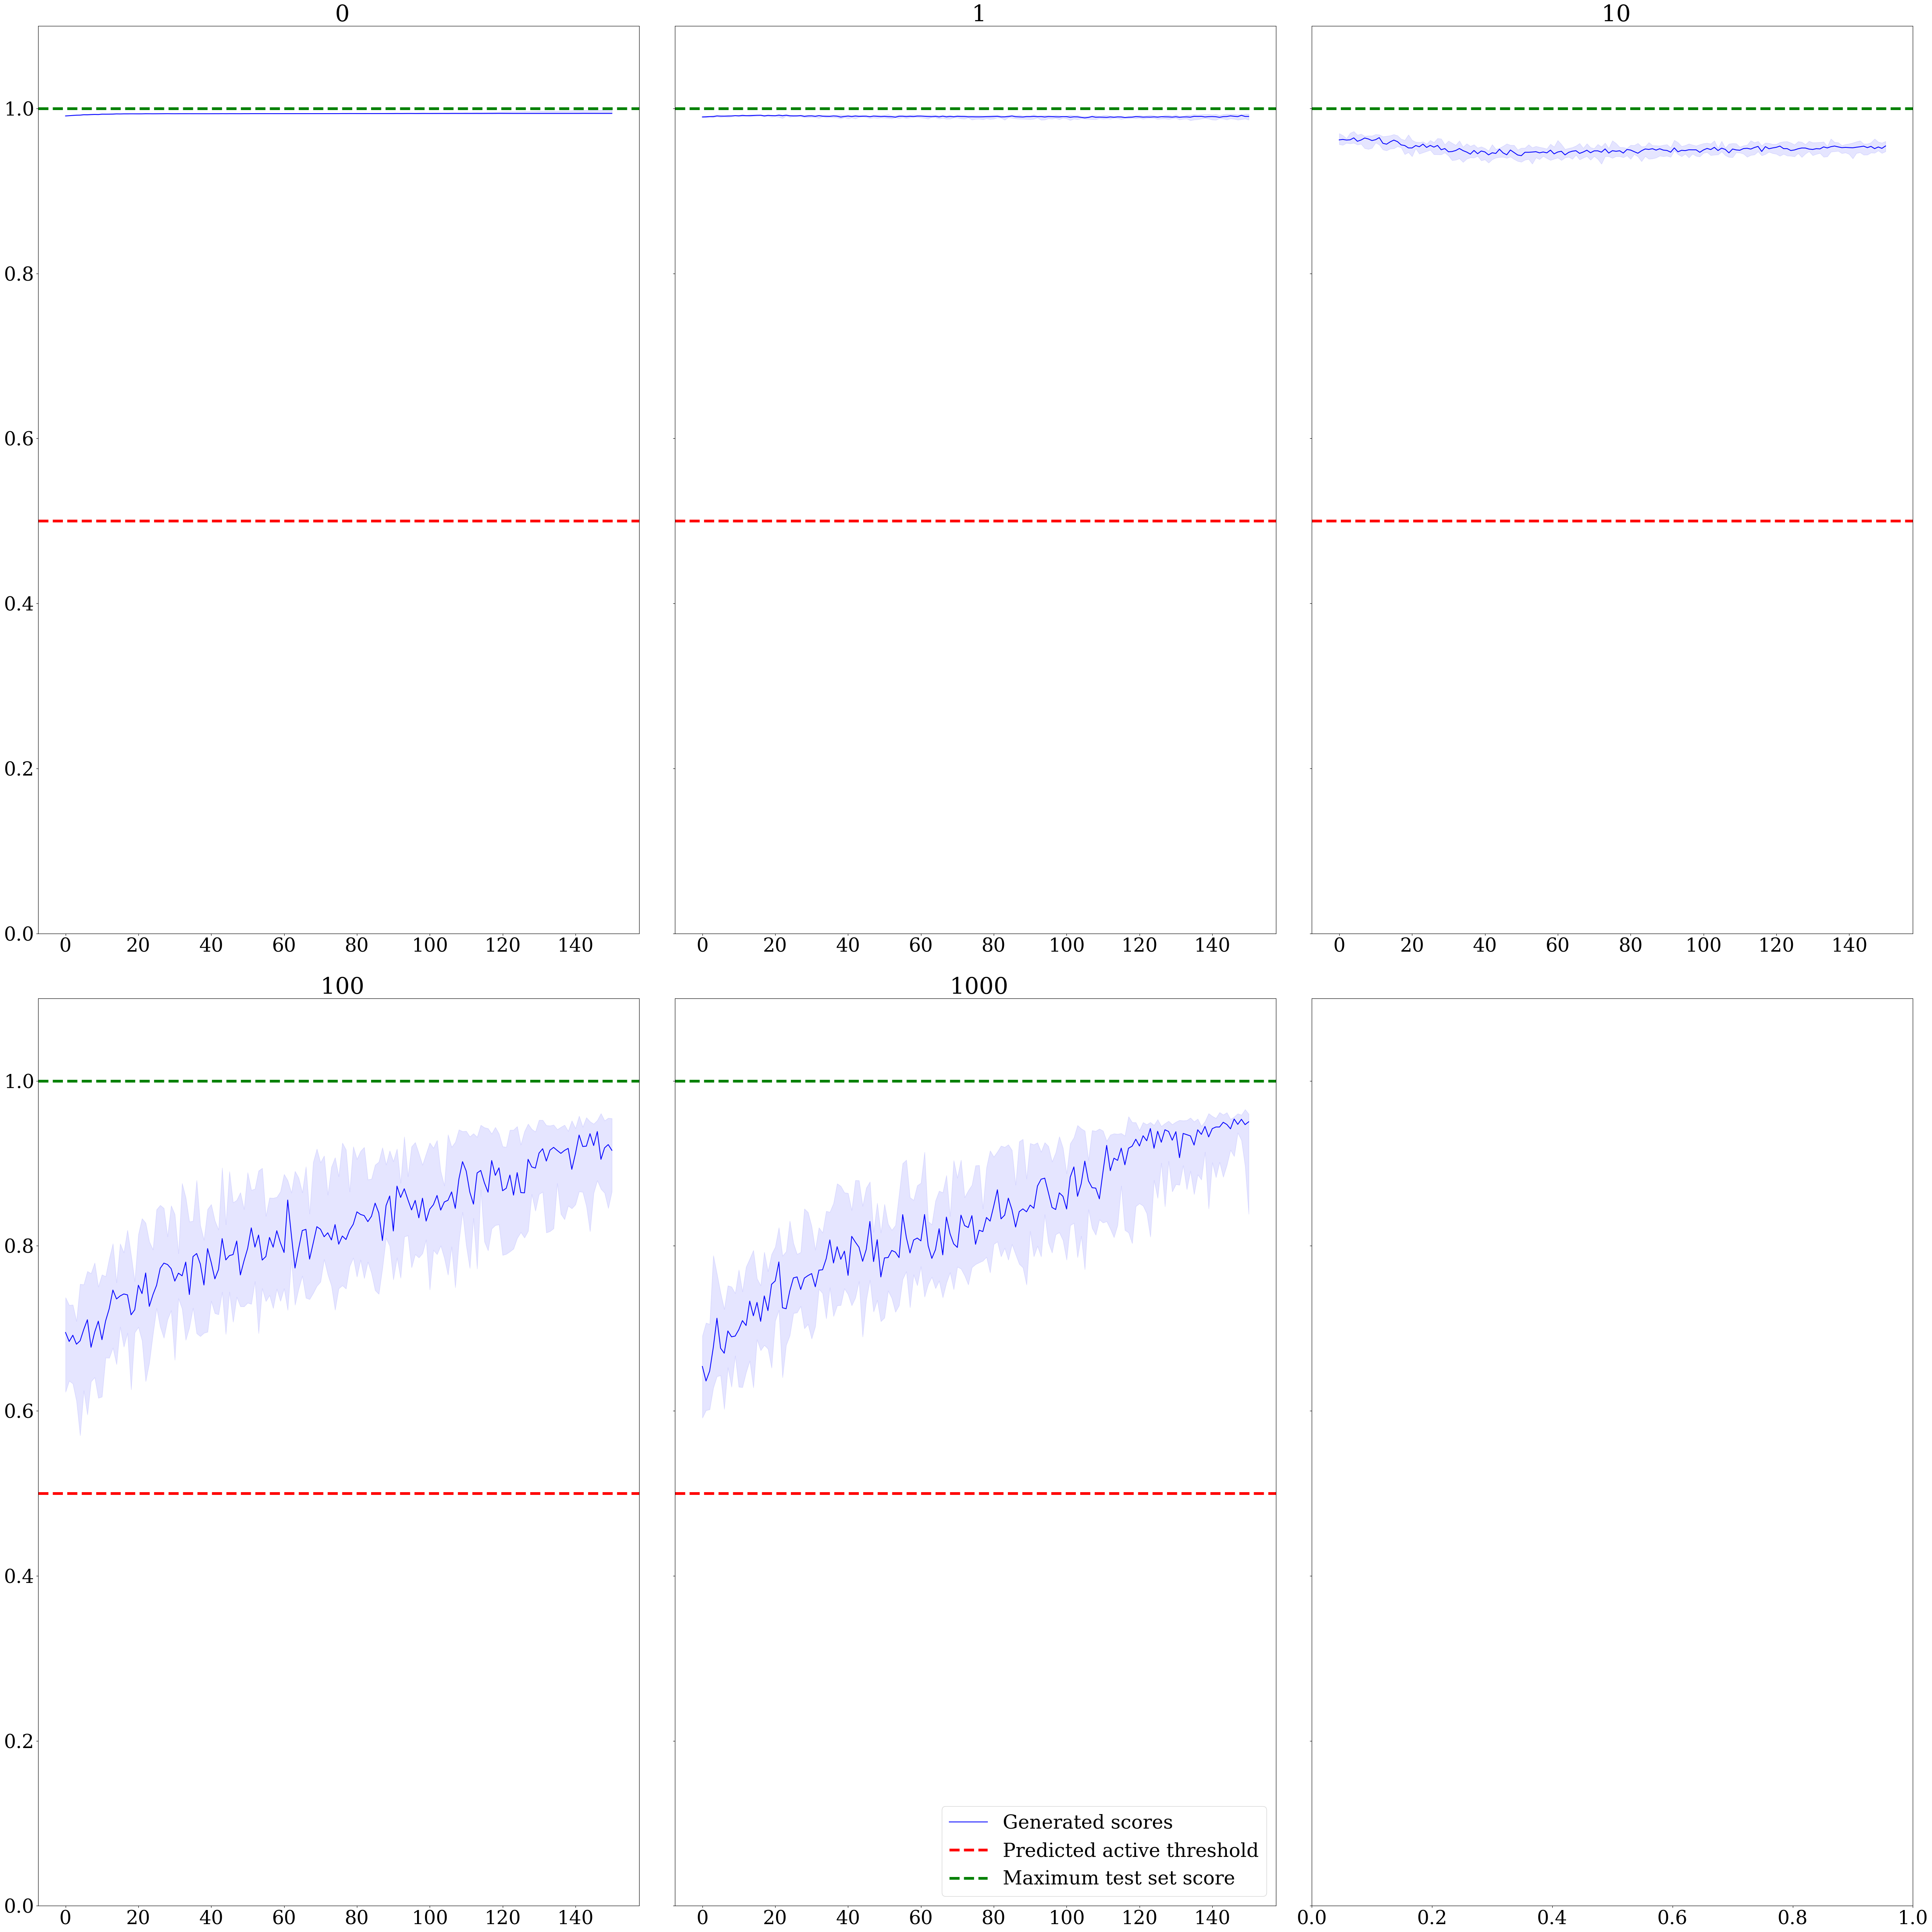

In [30]:
fig, axs = plt.subplots(
    figsize=(50, 50), nrows=max(1, math.ceil(len(runs) / 3)), ncols=3, sharey=True
)


titles = []
for run in runs:
    titles.append(run.split("_")[-3])

for i, run in enumerate(runs):
    ax = axs.flatten()[i]
    ax.set_title(titles[i])
    scores = np.array(scores_trajectories[runs.index(run)])
    median = np.median(scores, 0)
    q25 = np.percentile(scores, 2.5, axis=0)
    q75 = np.percentile(scores, 97.5, axis=0)

    ax.plot(median, c="b", label="Generated scores")
    ax.fill_between(np.arange(median.shape[0]), q25, q75, alpha=0.1, color="b")

    ax.axhline(
        y=0.5, linewidth=5, ls="--", color="r", label="Predicted active threshold"
    )
    ax.axhline(
        y=np.max(scores_test),
        linewidth=5,
        ls="--",
        color="g",
        label="Maximum test set score",
    )
ax.legend(loc=4)


plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig("graphs/scores_drd2.pdf", dpi=300)

# Additional functions

In [31]:
import random

optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(50):
    np.random.seed(seed)
    cluster = random.choice(range(5))
    criteria = "clogp"

    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.5]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []

                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)

                    scores = []
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(
                            AllChem.GetMorganFingerprintAsBitVect(mol, 2)
                        ).reshape(1, -1)
                        additional = 1 * clustering.predict(fp)[0] == cluster
                        scores_additional.append(additional)
                        scores.append(additional * prediction)

                        scores_prediction.append(prediction)
                    if np.sum(scores) == 0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

In [32]:
display_df_clustering = pd.DataFrame(
    zip(
        joint_scores,
        logp_scores,
        optimisation_scores,
        at_least_one,
        lcorr_list,
        beta_list,
        n_smiles_list,
    ),
    columns=[
        "Average score",
        "Additional score",
        "Optimization score",
        "At least one",
        "Length of correlation",
        "Beta",
        "N",
    ],
)

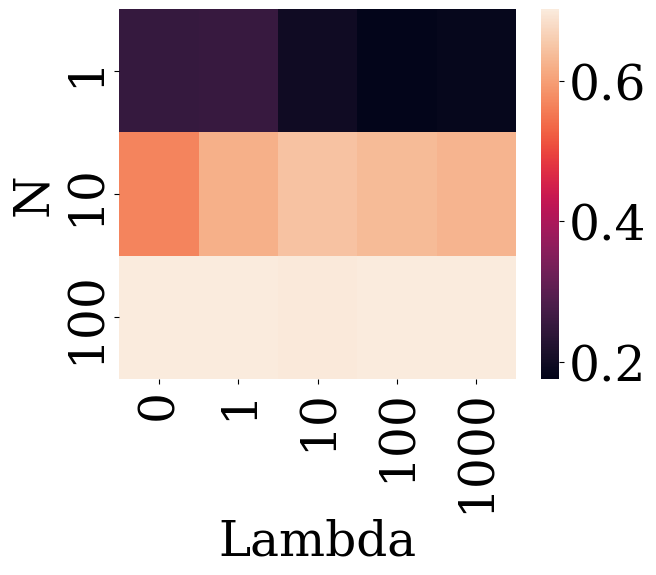

In [33]:
display_df_clustering = display_df_clustering.rename(columns={"Beta": "Lambda"})
display_df_clustering.to_csv("robustness_experiments/drd2_clustering.csv")

In [ ]:
display_df_clustering = pd.read_csv("robustness_experiments/drd2_clustering.csv")
pivoted = (
    display_df_clustering.groupby(["Lambda", "N"])
    .mean()
    .reset_index()
    .pivot(index="N", columns="Lambda", values="At least one")
)
sns.heatmap(pivoted)
plt.savefig("graphs/DRD2_clustering.pdf", dpi=300, bbox_inches="tight")

In [34]:
logps = []

for l in smiles_list:
    current_logp = []
    for s in l:
        fp = ecfp4([s])[0].reshape(1, -1)
        current_logp.append(MolLogP(Chem.MolFromSmiles(s)))
    logps.append(current_logp)

logp_test = []
for s in np.array(smiles_actives + smiles_inactives):
    fp = ecfp4([s])[0].reshape(1, -1)
    logp_test.append(MolLogP(Chem.MolFromSmiles(s)))

In [35]:
tpsa_test = []
for s in np.array(smiles_actives + smiles_inactives):
    tpsa_test.append(CalcTPSA(Chem.MolFromSmiles(s)))

In [36]:
def is_valid(
    s,
    criteria="mw",
    threshold_low_clogp=0,
    threshold_high_clogp=2,
    threshold_low_tpsa=50,
    threshold_high_tpsa=70,
    mw_threshold=350,
):
    mol = Chem.MolFromSmiles(s)
    logp = MolLogP(mol) >= threshold_low_clogp and MolLogP(mol) <= threshold_high_clogp
    tpsa = CalcTPSA(mol) >= threshold_low_tpsa and CalcTPSA(mol) <= threshold_high_tpsa
    mw = ExactMolWt(mol) < mw_threshold
    # return logp * tpsa
    if criteria == "mw":
        return mw
    elif criteria == "clogp":
        return logp
    else:
        return tpsa

In [37]:
import random

optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(50):
    np.random.seed(seed)

    length = np.random.uniform(1, 2)

    threshold_low_clogp = random.choice(logp_test) - length / 2
    threshold_high_clogp = threshold_low_clogp + length / 2

    length = np.random.uniform(10, 15)
    threshold_low_tpsa_random = np.random.uniform(70, 130)
    threshold_low_tpsa = threshold_low_tpsa_random
    # threshold_low_tpsa = random.choice([threshold_low_tpsa_random, threshold_low_tpsa_random, 140])
    # threshold_low_tpsa = np.random.uniform(70, 130)
    threshold_high_tpsa = threshold_low_tpsa + length

    cluster = random.choice(range(5))
    mw_threshold = random.choice([550, 650])
    criteria = "clogp"

    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.5]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []

                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)

                    scores = []
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(
                            AllChem.GetMorganFingerprintAsBitVect(mol, 2)
                        ).reshape(1, -1)

                        scores_additional.append(
                            is_valid(
                                s,
                                "clogp",
                                threshold_low_clogp,
                                threshold_high_clogp,
                                threshold_low_tpsa,
                                threshold_high_tpsa,
                                mw_threshold,
                            )
                        )
                        scores.append(
                            is_valid(
                                s,
                                "clogp",
                                threshold_low_clogp,
                                threshold_high_clogp,
                                threshold_low_tpsa,
                                threshold_high_tpsa,
                                mw_threshold,
                            )
                            * prediction
                        )

                        scores_prediction.append(prediction)
                    if np.sum(scores) == 0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

display_df_clogp = pd.DataFrame(
    zip(
        joint_scores,
        logp_scores,
        optimisation_scores,
        at_least_one,
        lcorr_list,
        beta_list,
        n_smiles_list,
    ),
    columns=[
        "Average score",
        "Additional score",
        "Optimization score",
        "At least one",
        "Length of correlation",
        "Beta",
        "N",
    ],
)

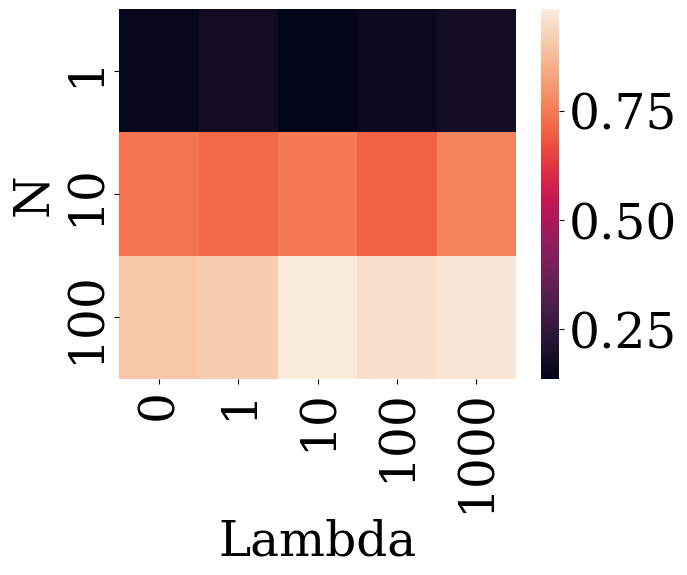

In [38]:
display_df_clogp = display_df_clogp.rename(columns={"Beta": "Lambda"})
display_df_clogp.to_csv("robustness_experiments/drd2_clogp.csv")

In [ ]:
display_df_clogp = pd.read_csv("robustness_experiments/drd2_clogp.csv")

pivoted = (
    display_df_clogp.groupby(["Lambda", "N"])
    .mean()
    .reset_index()
    .pivot(index="N", columns="Lambda", values="At least one")
)
sns.heatmap(pivoted)
plt.savefig("graphs/DRD2_clogp.pdf", dpi=300, bbox_inches="tight")

In [39]:
optimisation_scores = []
joint_scores = []
logp_scores = []
cvars = []
at_least_one = []

current_joint_scores = []
current_logp_scores = []
current_cvars = []
current_at_least_one = []

beta_list = []
lcorr_list = []
n_smiles_list = []

for seed in range(50):
    np.random.seed(seed)

    length = np.random.uniform(1, 2)

    threshold_low_clogp_random = np.random.uniform(0, 5)
    threshold_low_clogp = random.choice([threshold_low_clogp_random, 7])
    threshold_low_clogp = random.choice(logp_test) - length / 2
    threshold_high_clogp = threshold_low_clogp + length / 2

    length = np.random.uniform(5, 10)
    threshold_low_tpsa_random = np.random.uniform(70, 130)
    threshold_low_tpsa = random.choice(tpsa_test) - length / 2
    threshold_high_tpsa = threshold_low_tpsa + length / 2

    cluster = random.choice(range(5))
    mw_threshold = random.choice([550, 650])
    criteria = "clogp"

    for j, directory in enumerate(runs):
        smiles_generated = smiles_list[j]
        scores_generated = scores_list[j]
        for lcorr in [0.5]:
            for n_smiles in [1, 10, 100]:
                for seed_other in range(10):
                    np.random.seed(seed_other)

                    betas = [0, 1, 10, 100, 1000]
                    beta = round(betas[j], 2)
                    lcorr = round(lcorr, 2)

                    solutions_risk_adverse = random.sample(smiles_generated, n_smiles)
                    current_optimisation_score = []

                    n_smiles_list.append(n_smiles)
                    beta_list.append(beta)
                    lcorr_list.append(lcorr)

                    scores = []
                    scores_additional = []
                    scores_prediction = []
                    for s in solutions_risk_adverse:
                        mol = Chem.MolFromSmiles(s)
                        fp = ecfp4([s])[0].reshape(1, -1)
                        prediction = clf.predict_proba(fp)[0, 1]
                        prediction = np.random.binomial(1, prediction)
                        fp = np.array(
                            AllChem.GetMorganFingerprintAsBitVect(mol, 2)
                        ).reshape(1, -1)

                        scores_additional.append(
                            is_valid(
                                s,
                                "tpsa",
                                threshold_low_clogp,
                                threshold_high_clogp,
                                threshold_low_tpsa,
                                threshold_high_tpsa,
                                mw_threshold,
                            )
                        )
                        scores.append(
                            is_valid(
                                s,
                                "tpsa",
                                threshold_low_clogp,
                                threshold_high_clogp,
                                threshold_low_tpsa,
                                threshold_high_tpsa,
                                mw_threshold,
                            )
                            * prediction
                        )

                        scores_prediction.append(prediction)
                    if np.sum(scores) == 0:
                        at_least_one.append(0)
                    else:
                        at_least_one.append(1)
                    optimisation_scores.append(np.mean(scores_prediction))
                    logp_scores.append(np.mean(scores_additional))
                    joint_scores.append(np.mean(scores))

In [40]:
display_df_tpsa = pd.DataFrame(
    zip(
        joint_scores,
        logp_scores,
        optimisation_scores,
        at_least_one,
        lcorr_list,
        beta_list,
        n_smiles_list,
    ),
    columns=[
        "Average score",
        "Additional score",
        "Optimization score",
        "At least one",
        "Length of correlation",
        "Lambda",
        "N",
    ],
)

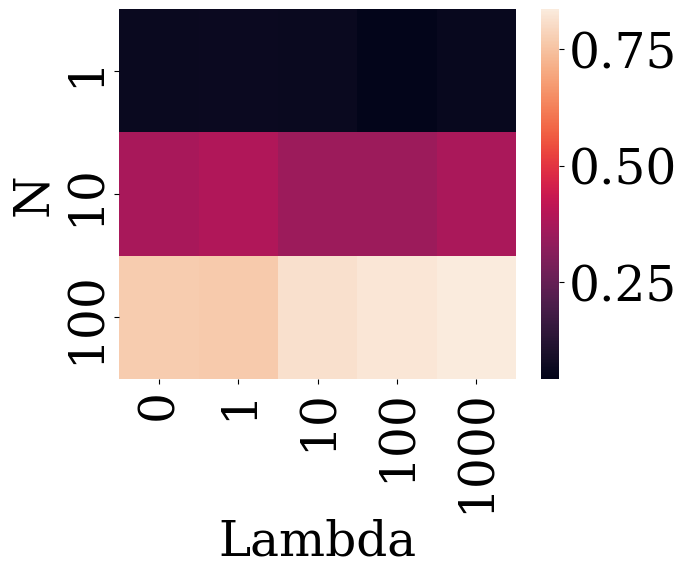

In [41]:
display_df_tpsa = display_df_tpsa.rename(columns={"Beta": "Lambda"})
display_df_tpsa.to_csv("robustness_experiments/drd2_tpsa.csv")

In [ ]:
display_df_tpsa = pd.read_csv("robustness_experiments/drd2_tpsa.csv")

pivoted = (
    display_df_tpsa.groupby(["Lambda", "N"])
    .mean()
    .reset_index()
    .pivot(index="N", columns="Lambda", values="At least one")
)
sns.heatmap(pivoted)
plt.savefig("graphs/DRD2_TPSA.pdf", dpi=300, bbox_inches="tight")